Fix the seeds

In [31]:
import numpy as np
import random
import torch

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(42)

# Dataset

In [32]:
!pip -q install torch
!pip -q install torchvision

In [33]:
import torch
from scipy.linalg import hadamard

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Cuda available: ", torch.cuda.is_available(), '\n')

# Creating Hadamard matrix, where each row is 32x32 hadamard pattern with {-1,1} elements
px = 32
H = torch.from_numpy(hadamard(px**2)).to(device)
# In real (physical) single pixel mesurements we use matrixes
Hplus = (H + 1) / 2
Hminus = (1 - H) / 2

Cuda available:  True 



Here are the functions, which create mesurements vectror for all patterns in Hadamard basis

In [34]:
def measurement(img):
    Mplus = torch.matmul(Hplus, img.flatten().float()).to(device)
    Mminus = torch.matmul(Hminus, img.flatten().float()).to(device)
    M = (Mplus - Mminus)

    return M

In [35]:
def batch_measurements(imgs):
    vect = torch.zeros(len(imgs), len(imgs[0]) ** 2)

    for i in range(len(imgs)):
        img = imgs[i].to(device)
        vect[i] = measurement(img)

    return vect

Dataset with single-pixel mesuarements and target images

In [36]:
from torchvision import transforms
from torch.utils.data.dataset import Dataset

class MesurementDataset(Dataset):
    def __init__(self, mnist):
        super().__init__()
        self.labels = mnist.targets
        images = mnist.data
        transform = transforms.Compose([transforms.ConvertImageDtype(torch.float32),
                                        transforms.Resize(32)])

        self.target_images = transform(images)

        self.measurements = batch_measurements(self.target_images).cpu()

    def __getitem__(self, indx):
        return self.measurements[indx], self.target_images[indx]

    def __len__(self):
        return len(self.measurements)

In [37]:
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from IPython.display import clear_output

train_set = MesurementDataset(MNIST(root='./MNIST', train=True, download=True))
test_set = MesurementDataset(MNIST(root='./MNIST', train=False, download=True))

batch_size = 64
# if you use cpu, you have to delete the num_workers
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

clear_output()

To create an underdefined system of equlations we need to select the most important ones, so we need to calculate variance

In [38]:
import numpy as np

variance = np.array([])
for i in range(1024):
    measurements_for_pattern = train_set[:][0][:,i]
    variance = np.append(variance, np.var(measurements_for_pattern.numpy()))

The most important patterns - with biggest dispersion trough the dataset

In [39]:
most_important = np.argsort(variance)[-64:]

# Model

In [40]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(64, 1000)
        self.fc2 = nn.Linear(1000, 2000)
        self.fc3 = nn.Linear(2000, 4000)
        self.fc4 = nn.Linear(4000, 2000)
        self.fc5 = nn.Linear(2000, 1024)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 64)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        x = self.activation(x)
        x = self.fc4(x)
        x = self.activation(x)
        x = self.fc5(x)
        return x

We can calculate the number of training parameters

In [41]:
model = Net().to(device)
sum(p.numel() for p in model.parameters() if p.requires_grad)

20122024

Class for plots

In [42]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

class ProgressPlotter:
  def __init__(self) -> None:
    self._history_dict = defaultdict(list)

  def add_scalar(self, tag: str, value)-> None:
    self._history_dict[tag].append(value)

  def display_keys(self,ax,tags):
    if isinstance(tags, str):
      tags = [tags]
    history_len = 0
    ax.grid()
    for key in tags:
      ax.plot(self._history_dict[key], marker="X",label=key)
      history_len = max(history_len,len(self.history_dict[key]))
    if len(tags) > 1:
      ax.legend(loc="lower left")
    else:
      ax.set_ylabel(key)
    ax.set_xlabel('epoch')
    ax.set_xticks(np.arange(history_len))
    ax.set_xticklabels(np.arange(history_len))

  def display(self,groups = None):
    # groups list ofkeys like [['loss_train','loss_val'],['accuracy']]
    clear_output()
    n_groups = len(groups)
    fig, ax = plt.subplots(n_groups, 1, figsize=(12, 3*n_groups))
    if n_groups == 1:
      ax = [ax]
    for i, keys in enumerate(groups):
      self.display_keys(ax[i],keys)
    fig.tight_layout()
    plt.show()

  @property
  def history_dict(self):
    return dict(self._history_dict)

MSELoss

In [43]:
model = Net().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Training

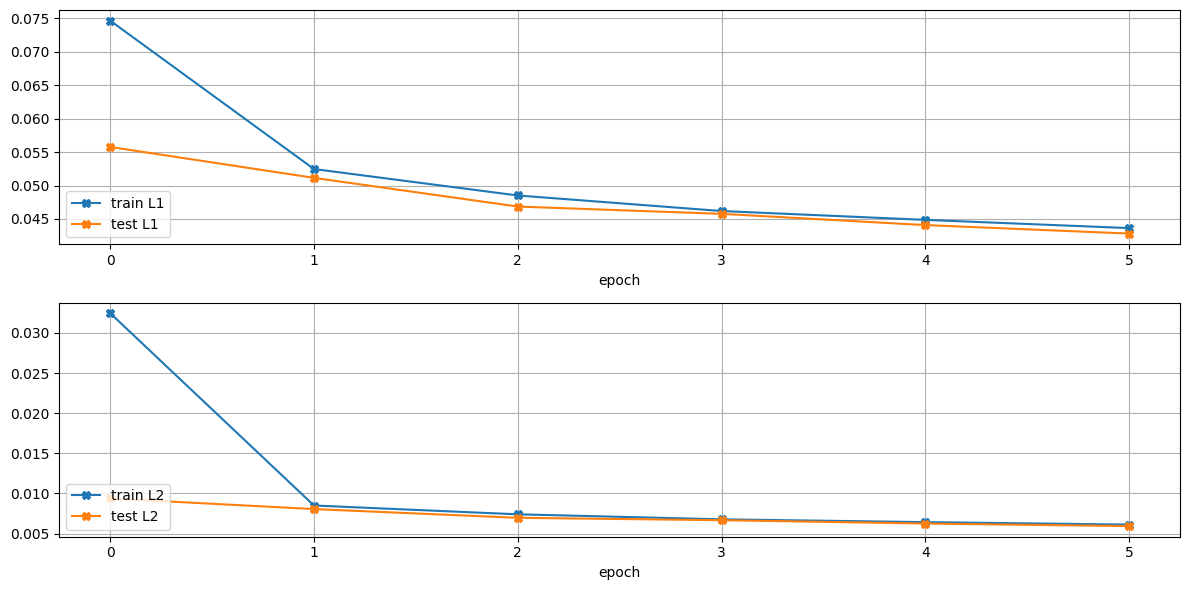

100%|██████████| 6/6 [01:23<00:00, 13.93s/it]

CPU times: user 59.9 s, sys: 4.7 s, total: 1min 4s
Wall time: 1min 23s


In [44]:
%%time

from tqdm.notebook import tqdm
from tqdm import trange

pp = ProgressPlotter()

num_epochs = 6
epochs = trange(num_epochs)

for epoch in epochs:

    l1 = 0
    l2 = 0

    model.train()

    for batch in tqdm(train_loader):
        measurements, target_imgs = batch
        measurements, target_imgs = measurements.to(device), target_imgs.to(device)

        optimizer.zero_grad()

        x = measurements[:, most_important]

        pred = model(x).to(device)
        pred = pred.view(-1, 32, 32).to(torch.float32)

        loss = criterion(pred, target_imgs)
        loss.backward()

        optimizer.step()
        l = loss.item()
        l2 += l

        l = float(torch.mean(abs(pred - target_imgs)).cpu())
        l1 += l

    l1 /= len(train_loader)
    l2 /= len(train_loader)

    val_l1 = 0
    val_l2 = 0

    model.eval()

    for batch in tqdm(test_loader):
        measurements, target_imgs = batch
        measurements, target_imgs = measurements.to(device), target_imgs.to(device)

        x = measurements[:, most_important]

        pred = model(x).to(device)
        pred = pred.view(-1, 32, 32).to(torch.float32)

        loss = criterion(pred, target_imgs)

        l = loss.item()
        val_l2 += l

        l = float(torch.mean(abs(pred - target_imgs)).cpu())
        val_l1 += l

    val_l1 /= len(test_loader)
    val_l2 /= len(test_loader)

    pp.add_scalar('train L1', l1)
    pp.add_scalar('train L2', l2)

    pp.add_scalar('test L1', val_l1)
    pp.add_scalar('test L2', val_l2)

    pp.display([['train L1','test L1'],['train L2','test L2']])

Let's look at the ground truth and model's predictions  

In [45]:
measurements, target_imgs = next(iter(test_loader))
x = measurements[:, most_important].to(device)
pred = model(x).to(device)

true_imgs = torch.reshape(target_imgs, (64, 32, 32))
pred = torch.reshape(pred, (64, 32, 32)).to(device)
pred = pred.detach().to(device)

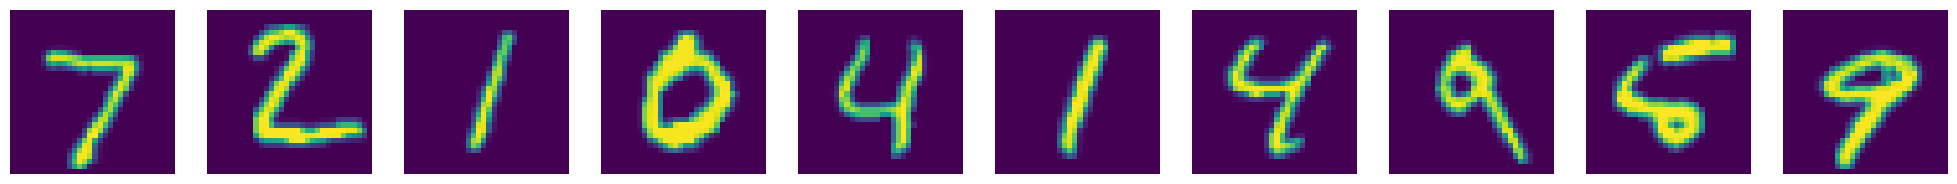

In [46]:
plt.figure(figsize = (25.0, 25.0))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis("off")
  plt.imshow(true_imgs[i].numpy())

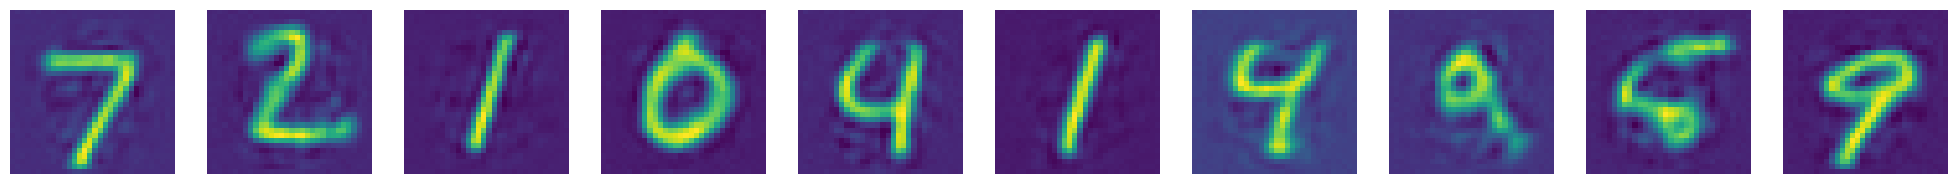

In [47]:
plt.figure(figsize = (25.0, 25.0))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis("off")
  plt.imshow(pred[i].to("cpu").numpy())

In [48]:
!pip -q install torchmetrics

In [49]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

s = 0
ssim = StructuralSimilarityIndexMeasure()
target_image = true_imgs.unsqueeze(1)
image = pred.unsqueeze(1)
s = ssim(image.cpu(), target_image.cpu())
s

tensor(0.7960)